In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import tifffile
import matplotlib.pyplot as plt
import cv2

import random

In [2]:
DEFAULT_RANDOM_SEED = 2021

seed = DEFAULT_RANDOM_SEED

random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
'''DATA LOADER'''
class SWEDDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None, target_transform=None, index=True):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.target_transform = target_transform
        self.index = index

        self.data_dir = os.path.join(root_dir, mode)
        self.image_dir = os.path.join(self.data_dir, 'images')
        self.label_dir = os.path.join(self.data_dir, 'labels')
        
        image_files = sorted([f for f in os.listdir(self.image_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        label_files = sorted([f for f in os.listdir(self.label_dir) 
                            if f.endswith('.npy' if mode in ['train', 'val'] else '.tif')])
        
        self.pairs = []
        label_suffix = '_chip_' if mode in ['train', 'val'] else '_label_'
        image_dict = {f.replace('_image_', label_suffix): f for f in image_files}
        
        for label_file in label_files:
            if label_file in image_dict:
                self.pairs.append((image_dict[label_file], label_file))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, label_file = self.pairs[idx]
        img_path = os.path.join(self.image_dir, img_file)
        label_path = os.path.join(self.label_dir, label_file)
        
        if self.mode in ['train', 'val']:
            image = np.load(img_path)
            label = np.load(label_path)
        else:
            image = tifffile.imread(img_path)
            label = tifffile.imread(label_path)
            
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
        
        if self.mode in ['train', 'val']:
            image = image.permute(2, 0, 1)
        elif self.mode == 'test':
            image = image.permute(0, 2, 1)
            label = label.unsqueeze(0)
            label = torch.rot90(label, 1, [1, 2])
            label = torch.flip(label, [1])

        image = image / 2.0**15     # jp2 images are 8 to 16 bit
        label = label > 0.0         # binary label

        # bands: B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12
        if self.index:
            ndwi1 = (image[2] - image[7]) / (image[2] + image[7] + 1e-6)
            
            # downsample
            lowres = image[2].T.cpu().numpy()
            original_shape = lowres.shape
            lowres = cv2.resize(
                lowres, 
                (lowres.shape[1] // 2, lowres.shape[0] // 2), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = cv2.resize(
                lowres, 
                (original_shape[1], original_shape[0]), 
                interpolation=cv2.INTER_CUBIC
            )
            lowres = torch.from_numpy(lowres.T).float()

            ndwi2 = (lowres - image[10]) / (lowres + image[10] + 1e-6)

            image = torch.cat([image, ndwi1.unsqueeze(0), ndwi2.unsqueeze(0)], dim=0)
            
        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

In [4]:
'''GET DATA LOADER'''
def get_dataloaders(root_dir, batch_size=32, num_workers=4, train_transform=None, test_transform=None, device='cuda'):
    train_dataset = SWEDDataset(root_dir, mode='train', transform=train_transform)
    test_dataset = SWEDDataset(root_dir, mode='test', transform=test_transform)

    # train_dataset, val_dataset, _ = random_split(train_dataset, [round(0.04 * len(train_dataset)), 
    #                                                              round(0.02 * len(train_dataset)), 
    #                                                              len(train_dataset) - round(0.06 * len(train_dataset))])

    train_dataset, val_dataset = random_split(train_dataset, [int(0.8 * len(train_dataset)),  
                                                                 len(train_dataset) - int(0.8 * len(train_dataset))])

    print(f'Train size: {len(train_dataset)}')
    print(f'Validation size: {len(val_dataset)}')
    print(f'Test size: {len(test_dataset)}')
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

In [5]:
'''DISPLAY SAMPLES'''
def display_samples(dataloader, num_samples=5, index=True):
    # Get a batch
    images, masks = next(iter(dataloader))

    # Move to CPU for visualization
    images = images.cpu()
    masks = masks.cpu()

    # Only display up to the requested number of samples
    num_samples = min(num_samples, len(images))
    
    rows = 4 if index else 2
    fig, axes = plt.subplots(rows, num_samples, figsize=(5*num_samples, 5*rows))
    
    idx = 0
    while(idx < num_samples):
        i = np.random.randint(0, len(images))
        if masks[i].sum() == 0:
            continue

        # Display RGB channels (assuming bands 3,2,1 are RGB)
        rgb_img = images[i][[3,2,1]].permute(1,2,0)
        # Normalize for visualization
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())
        
        axes[0, idx].imshow(rgb_img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(f'Image {idx+1}')
        
        axes[1, idx].imshow(masks[i][0], cmap='gray')
        axes[1, idx].axis('off')
        axes[1, idx].set_title(f'Mask {idx+1}')

        if index:
            axes[2, idx].imshow(images[i][12], cmap='gray')
            axes[2, idx].axis('off')
            axes[2, idx].set_title(f'NDWI1 {idx+1}')

            axes[3, idx].imshow(images[i][13], cmap='gray')
            axes[3, idx].axis('off')
            axes[3, idx].set_title(f'NDWI2 {idx+1}')

        idx += 1
    
    plt.tight_layout()
    plt.show()

In [6]:
'''VISUALIZE SAMPLES'''
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(f"Using device: {device}")

root_dir = "/kaggle/input/sentinel-2-water-edges-dataset/SWED"
train_loader, val_loader, test_loader = get_dataloaders(root_dir, batch_size=16, num_workers=4)

# Display 5 samples from training set
# display_samples(train_loader, num_samples=5)
# display_samples(test_loader, num_samples=5)

'''
# in case we need standardization

channel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,
        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])
channel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,
        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])
'''

Using device: cuda
Train size: 22579
Validation size: 5645
Test size: 98


'\n# in case we need standardization\n\nchannel-wise mean:  tensor([ 532.5187,  636.4246,  892.5240, 1049.9366, 1307.1577, 1738.9155,\n        1915.7476, 1995.0083, 2055.7939, 2086.2705, 2001.6875, 1491.3577])\nchannel-wise std:  tensor([ 679.3956,  750.0253,  923.6580, 1273.5732, 1366.0400, 1500.5621,\n        1623.3806, 1687.1169, 1720.2144, 1827.5625, 1932.8875, 1631.7715])\n'

In [7]:
!pip install -q --upgrade torchmetrics

In [8]:
'''TRAINER CLASS'''
from tqdm import tqdm
from torchmetrics.classification import (
    BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score, BinaryJaccardIndex, 
    BinaryCohenKappa, BinaryMatthewsCorrCoef, Accuracy
)
import pandas as pd

class Trainer:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, test_loader, device, 
                 scheduler=None, early_stopping_patience=10, min_delta=0.001):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        self.scheduler = scheduler
        self.predictions = None

        # Early stopping parameters
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

    def save_checkpoint(self, epoch, train_loss, val_loss, best_model=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses
        }
        if self.scheduler:
            checkpoint['scheduler_state_dict'] = self.scheduler.state_dict()

        if best_model:
            save_path = 'best_model.pt'
        else:
            save_path = 'checkpoint.pt'
        torch.save(checkpoint, save_path)
    
    def load_checkpoint(self, checkpoint_path="best_model.pt"):
        if not os.path.exists(checkpoint_path):
            return 0  # Start from scratch if no checkpoint exists
            
        checkpoint = torch.load(checkpoint_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        if self.scheduler and 'scheduler_state_dict' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Restore loss history
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        
        return checkpoint['epoch']

    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for images, labels in tqdm(self.train_loader, desc="train"):
            images, labels = images.to(self.device), labels.to(self.device).float()
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs.squeeze(), labels.squeeze())
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.train_loader.dataset)

    def val_epoch(self):
        self.model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(self.val_loader, desc="validation"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
        
        return running_loss / len(self.val_loader.dataset)
    
    def plot_losses(self, train_losses, val_losses):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()
    
    def train(self, num_epochs, do_plot=True, plot_interval=5, resume=True):
        # Initialize or restore from checkpoint
        self.train_losses = []
        self.val_losses = []
        start_epoch = self.load_checkpoint('checkpoint.pt') if resume else 0
        self.best_val_loss = float('inf')
        self.early_stopping_counter = 0
        self.early_stopped = False

        if start_epoch > 0:
            print("Training resumed from epoch ", start_epoch)
    
        for epoch in range(start_epoch, num_epochs):
            if self.early_stopped:
                print("Early stopping triggered.")
                break

            train_loss = self.train_epoch()
            val_loss = self.val_epoch()
    
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            
            if self.scheduler:
                self.scheduler.step(val_loss)
    
            print(f"Epoch {epoch + 1}/{num_epochs}")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")

            self.save_checkpoint(epoch + 1, train_loss, val_loss)
    
            # Early stopping logic
            if val_loss < self.best_val_loss - self.min_delta:
                self.best_val_loss = val_loss
                self.early_stopping_counter = 0
                # Save the best model
                self.save_checkpoint(epoch + 1, train_loss, val_loss, best_model=True)
                print(f"New best model saved at epoch {epoch + 1}")
            else:
                self.early_stopping_counter += 1
                print(f"No improvement. Early stopping counter: {self.early_stopping_counter}")
                
                if self.early_stopping_counter >= self.early_stopping_patience:
                    self.early_stopped = True
                    print("Early stopping triggered.")
    
            if do_plot and (epoch > 0 and epoch % plot_interval == 0 or epoch == num_epochs - 1):
                self.plot_losses(self.train_losses, self.val_losses)
        
        # Load the best model at the end of training
        if os.path.exists('best_model.pt'):
            self.load_checkpoint('best_model.pt')
        
        return self.early_stopped


    def test(self, thres=0.5):
        self.load_checkpoint('best_model.pt')
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() > thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
                loss = self.criterion(outputs.squeeze(), labels.squeeze())
                running_loss += loss.item() * images.size(0)
                all_predictions.extend(outputs.squeeze().cpu().numpy())

        metrics = self.evaluate_torchmetrics(y_pred, y_true)
        metrics.loc[len(metrics)] = ['loss', running_loss / len(self.test_loader.dataset)]  

        return metrics

    def evaluate_torchmetrics(self, y_pred, y_true):
        metrics = {
            "accuracy": BinaryAccuracy(),
            "bal_accuracy": Accuracy(num_classes=2, task="multiclass", average="macro"),
            "precision": BinaryPrecision(),
            "recall": BinaryRecall(),
            "f1_score": BinaryF1Score(),
            "jaccard_index": BinaryJaccardIndex(),
            "cohen_kappa": BinaryCohenKappa(),
            "mcc": BinaryMatthewsCorrCoef()
        }
    
        y_pred = torch.tensor(y_pred).float()
        y_true = torch.tensor(y_true).float()
    
        # result dataframe
        results = pd.DataFrame(columns=["Metric", "Value"])
        for metric_name, metric in metrics.items():
            metric_value = metric(y_pred, y_true)
            results.loc[len(results)] = [metric_name, metric_value.item()]  
            
        return results

    def test_visualize(self, n_samples=5, thres=0.5): 
        self.model.eval()
        y_true = None
        y_pred = None

        with torch.no_grad():
            for images, labels in tqdm(self.test_loader, desc="Testing"):
                images, labels = images.to(self.device), labels.to(self.device).float()
                outputs = self.model(images)

                if y_true is None:
                    y_true = labels.squeeze().cpu().numpy()
                    y_pred = (outputs.squeeze().cpu().numpy() >thres).astype(int)
                else:
                    y_true = np.concatenate((y_true, labels.squeeze().cpu().numpy()))
                    y_pred = np.concatenate((y_pred, (outputs.squeeze().cpu().numpy() > 0.5).astype(int)))
                
        for _ in range(n_samples):
            idx = random.randint(0, len(y_true))
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            axes[0].imshow(y_true[idx].reshape(256, 256), cmap='gray')
            axes[0].set_title('True')
            axes[1].imshow(y_pred[idx].reshape(256, 256), cmap='gray')
            axes[1].set_title('Predicted')
            plt.show()


In [9]:
channels = 14

In [10]:
!pip install -q einops

In [11]:
from einops import rearrange, repeat


class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, head_num):
        super().__init__()

        self.head_num = head_num
        self.dk = (embedding_dim // head_num) ** (1 / 2)

        self.qkv_layer = nn.Linear(embedding_dim, embedding_dim * 3, bias=False)
        self.out_attention = nn.Linear(embedding_dim, embedding_dim, bias=False)

    def forward(self, x, mask=None):
        qkv = self.qkv_layer(x)

        query, key, value = tuple(rearrange(qkv, 'b t (d k h ) -> k b h t d ', k=3, h=self.head_num))
        energy = torch.einsum("... i d , ... j d -> ... i j", query, key) * self.dk

        if mask is not None:
            energy = energy.masked_fill(mask, -np.inf)

        attention = torch.softmax(energy, dim=-1)

        x = torch.einsum("... i j , ... j d -> ... i d", attention, value)

        x = rearrange(x, "b h t d -> b t (h d)")
        x = self.out_attention(x)

        return x


class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_dim):
        super().__init__()

        self.mlp_layers = nn.Sequential(
            nn.Linear(embedding_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_dim, embedding_dim),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        x = self.mlp_layers(x)

        return x


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim):
        super().__init__()

        self.multi_head_attention = MultiHeadAttention(embedding_dim, head_num)
        self.mlp = MLP(embedding_dim, mlp_dim)

        self.layer_norm1 = nn.LayerNorm(embedding_dim)
        self.layer_norm2 = nn.LayerNorm(embedding_dim)

        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        _x = self.multi_head_attention(x)
        _x = self.dropout(_x)
        x = x + _x
        x = self.layer_norm1(x)

        _x = self.mlp(x)
        x = x + _x
        x = self.layer_norm2(x)

        return x


class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, head_num, mlp_dim, block_num=12):
        super().__init__()

        self.layer_blocks = nn.ModuleList(
            [TransformerEncoderBlock(embedding_dim, head_num, mlp_dim) for _ in range(block_num)])

    def forward(self, x):
        for layer_block in self.layer_blocks:
            x = layer_block(x)

        return x


class ViT(nn.Module):
    def __init__(self, img_dim, in_channels, embedding_dim, head_num, mlp_dim,
                 block_num, patch_dim, classification=True, num_classes=1):
        super().__init__()

        self.patch_dim = patch_dim
        self.classification = classification
        self.num_tokens = (img_dim // patch_dim) ** 2
        self.token_dim = in_channels * (patch_dim ** 2)

        self.projection = nn.Linear(self.token_dim, embedding_dim)
        self.embedding = nn.Parameter(torch.rand(self.num_tokens + 1, embedding_dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        self.dropout = nn.Dropout(0.1)

        self.transformer = TransformerEncoder(embedding_dim, head_num, mlp_dim, block_num)

        if self.classification:
            self.mlp_head = nn.Linear(embedding_dim, num_classes)

    def forward(self, x):
        img_patches = rearrange(x,
                                'b c (patch_x x) (patch_y y) -> b (x y) (patch_x patch_y c)',
                                patch_x=self.patch_dim, patch_y=self.patch_dim)

        batch_size, tokens, _ = img_patches.shape

        project = self.projection(img_patches)
        token = repeat(self.cls_token, 'b ... -> (b batch_size) ...',
                       batch_size=batch_size)

        patches = torch.cat([token, project], dim=1)
        patches += self.embedding[:tokens + 1, :]

        x = self.dropout(patches)
        x = self.transformer(x)
        x = self.mlp_head(x[:, 0, :]) if self.classification else x[:, 1:, :]

        return x


if __name__ == '__main__':
    vit = ViT(img_dim=128,
              in_channels=3,
              patch_dim=16,
              embedding_dim=512,
              block_num=6,
              head_num=4,
              mlp_dim=1024)
    print(sum(p.numel() for p in vit.parameters()))
    print(vit(torch.rand(1, 3, 128, 128)).shape)

13032449
torch.Size([1, 1])


In [12]:
import torch
import torch.nn as nn
from einops import rearrange


class EncoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, base_width=64):
        super().__init__()

        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        width = int(out_channels * (base_width / 64))

        self.conv1 = nn.Conv2d(in_channels, width, kernel_size=1, stride=1, bias=False)
        self.norm1 = nn.BatchNorm2d(width)

        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=2, groups=1, padding=1, dilation=1, bias=False)
        self.norm2 = nn.BatchNorm2d(width)

        self.conv3 = nn.Conv2d(width, out_channels, kernel_size=1, stride=1, bias=False)
        self.norm3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x_down = self.downsample(x)

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = x + x_down
        x = self.relu(x)

        return x


class DecoderBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor=2):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=True)
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, x_concat=None):
        x = self.upsample(x)

        if x_concat is not None:
            x = torch.cat([x_concat, x], dim=1)

        x = self.layer(x)
        return x


class Encoder(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.encoder1 = EncoderBottleneck(out_channels, out_channels * 2, stride=2)
        self.encoder2 = EncoderBottleneck(out_channels * 2, out_channels * 4, stride=2)
        self.encoder3 = EncoderBottleneck(out_channels * 4, out_channels * 8, stride=2)

        self.vit_img_dim = img_dim // patch_dim
        self.vit = ViT(self.vit_img_dim, out_channels * 8, out_channels * 8,
                       head_num, mlp_dim, block_num, patch_dim=1, classification=False)

        self.conv2 = nn.Conv2d(out_channels * 8, 512, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm2d(512)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x1 = self.relu(x)

        x2 = self.encoder1(x1)
        x3 = self.encoder2(x2)
        x = self.encoder3(x3)

        x = self.vit(x)
        x = rearrange(x, "b (x y) c -> b c x y", x=self.vit_img_dim, y=self.vit_img_dim)

        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu(x)

        return x, x1, x2, x3


class Decoder(nn.Module):
    def __init__(self, out_channels, class_num):
        super().__init__()

        self.decoder1 = DecoderBottleneck(out_channels * 8, out_channels * 2)
        self.decoder2 = DecoderBottleneck(out_channels * 4, out_channels)
        self.decoder3 = DecoderBottleneck(out_channels * 2, int(out_channels * 1 / 2))
        self.decoder4 = DecoderBottleneck(int(out_channels * 1 / 2), int(out_channels * 1 / 8))

        self.conv1 = nn.Conv2d(int(out_channels * 1 / 8), class_num, kernel_size=1)

    def forward(self, x, x1, x2, x3):
        x = self.decoder1(x, x3)
        x = self.decoder2(x, x2)
        x = self.decoder3(x, x1)
        x = self.decoder4(x)
        x = self.conv1(x)

        return x


class TransUNet(nn.Module):
    def __init__(self, img_dim, in_channels, out_channels, head_num, mlp_dim, block_num, patch_dim, class_num):
        super().__init__()

        self.encoder = Encoder(img_dim, in_channels, out_channels,
                               head_num, mlp_dim, block_num, patch_dim)

        self.decoder = Decoder(out_channels, class_num)

    def forward(self, x):
        x, x1, x2, x3 = self.encoder(x)
        x = self.decoder(x, x1, x2, x3)

        return x



transunet = TransUNet(img_dim=256,
                      in_channels=channels,
                      out_channels=128,
                      head_num=4,
                      mlp_dim=512,
                      block_num=8,
                      patch_dim=16,
                      class_num=1).to(device)

print(sum(p.numel() for p in transunet.parameters()))
print(transunet(torch.randn(1, channels, 256, 256).to(device)).shape)

67148273
torch.Size([1, 1, 256, 256])


In [13]:
model = transunet
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 256.217MB


In [14]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.6, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        pred, target = pred.squeeze(), target.squeeze()
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        return focal_loss.mean()

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


pred = torch.randn(16, 128, 128).float()
target = torch.randint(0, 2, (16, 128, 128)).float()

# focal_loss = FocalLoss(alpha=0.75, gamma=2.0)
# focal_loss(pred, target)
loss(pred, target)

tensor(13251.9043)

validation: 100%|██████████| 353/353 [00:59<00:00,  5.91it/s]


Epoch 1/5
Training Loss: 2342.3495
Validation Loss: 1349.8095
New best model saved at epoch 1


validation: 100%|██████████| 353/353 [00:59<00:00,  5.92it/s]


Epoch 2/5
Training Loss: 1519.5764
Validation Loss: 3981.6080
No improvement. Early stopping counter: 1


validation: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]


Epoch 3/5
Training Loss: 1306.9361
Validation Loss: 4347.6445
No improvement. Early stopping counter: 2


validation: 100%|██████████| 353/353 [00:59<00:00,  5.93it/s]


Epoch 4/5
Training Loss: 1170.4630
Validation Loss: 1104.0285
New best model saved at epoch 4


validation: 100%|██████████| 353/353 [01:00<00:00,  5.86it/s]


Epoch 5/5
Training Loss: 1255.4285
Validation Loss: 1611.9326
No improvement. Early stopping counter: 1


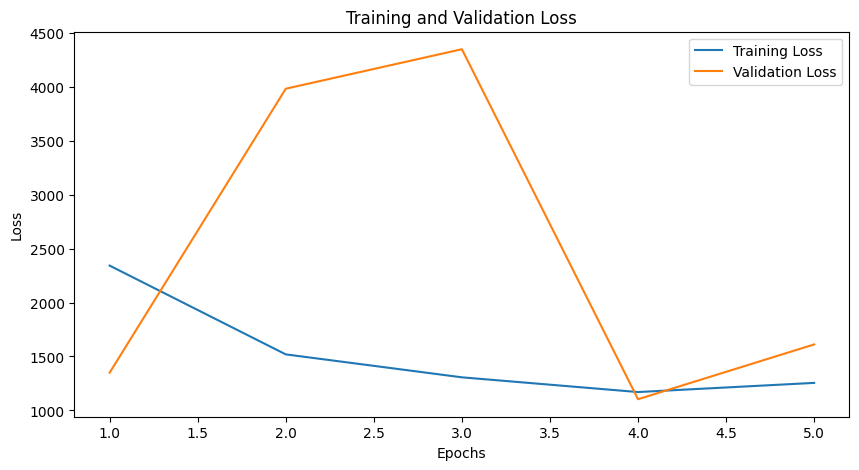

/tmp/ipykernel_23/2814709985.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


False

In [15]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

criterion = FocalLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4, verbose=True)

trainer = Trainer(model, criterion, optimizer, train_loader, val_loader, test_loader, device, scheduler)
trainer.train(num_epochs=5)

In [16]:
metrics_df = trainer.test(thres=0.5)
metrics_df

/tmp/ipykernel_23/2814709985.py:52: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)
Testing: 100%|██████████| 7/7 [00:02<00:00,  2.56i

,Metric,Value
0,accuracy,0.892664
1,bal_accuracy,0.897371
2,precision,0.942881
3,recall,0.864917
4,f1_score,0.902218
5,jaccard_index,0.821855
6,cohen_kappa,0.783748
7,mcc,0.787337
8,loss,2809.984334


Testing: 100%|██████████| 7/7 [00:01<00:00,  3.53it/s]


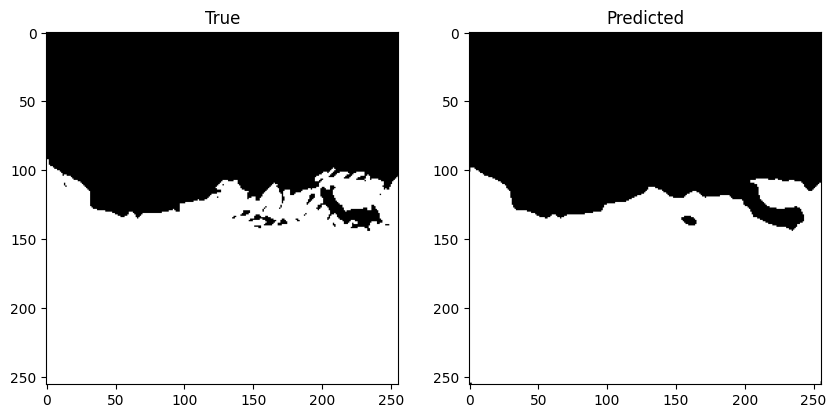

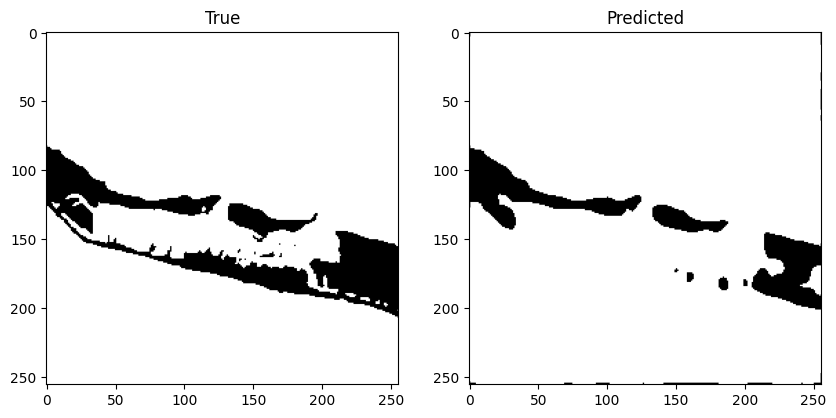

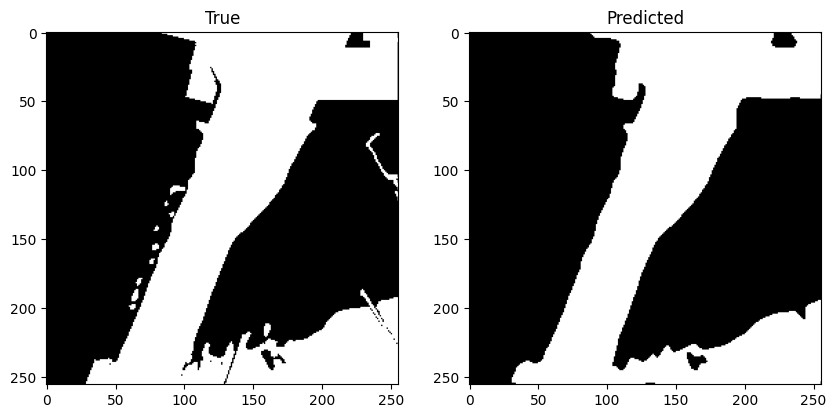

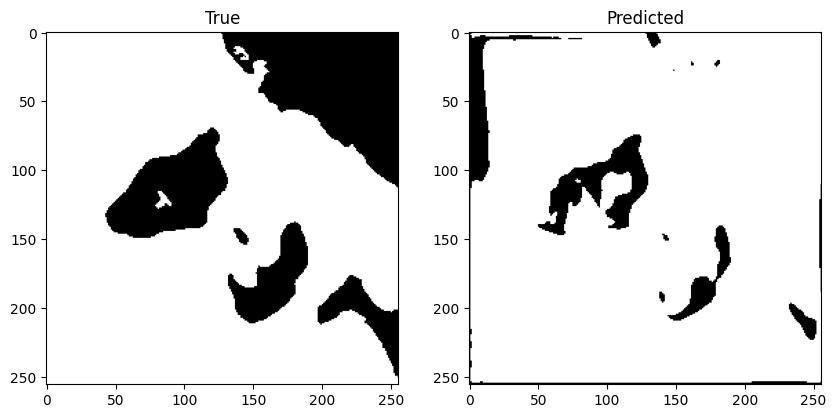

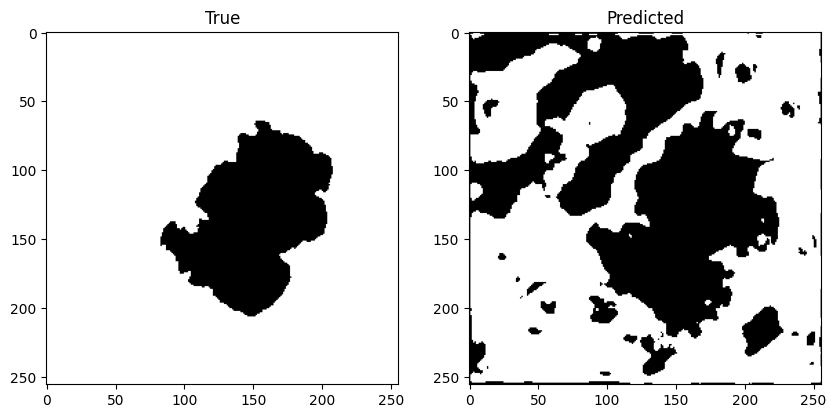

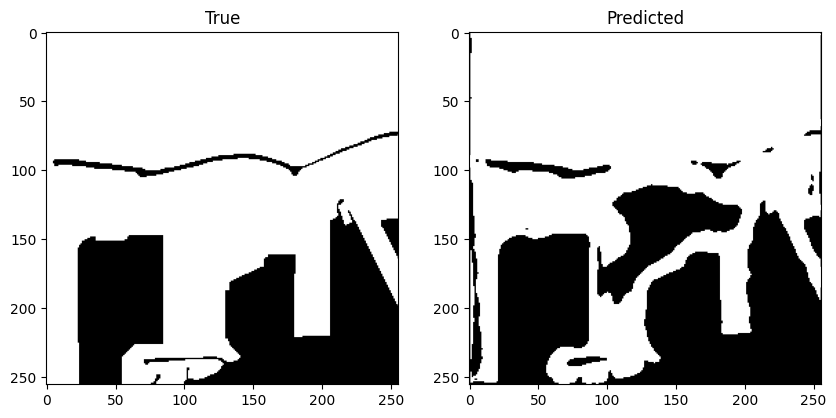

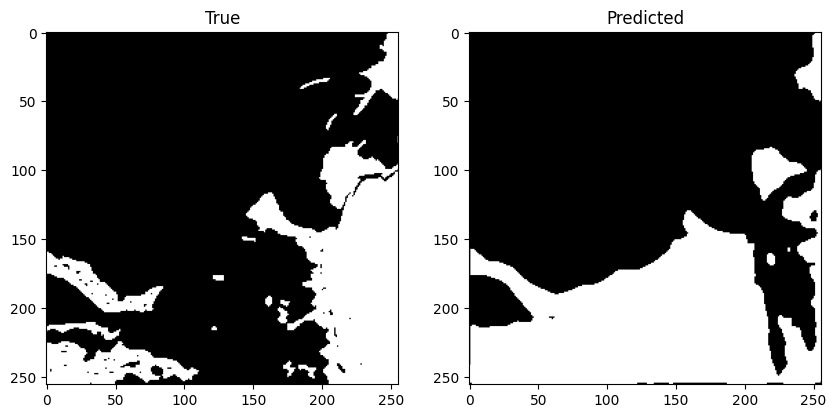

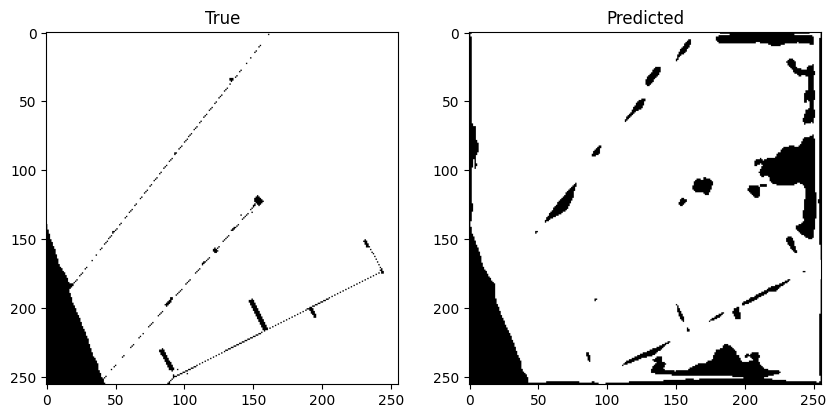

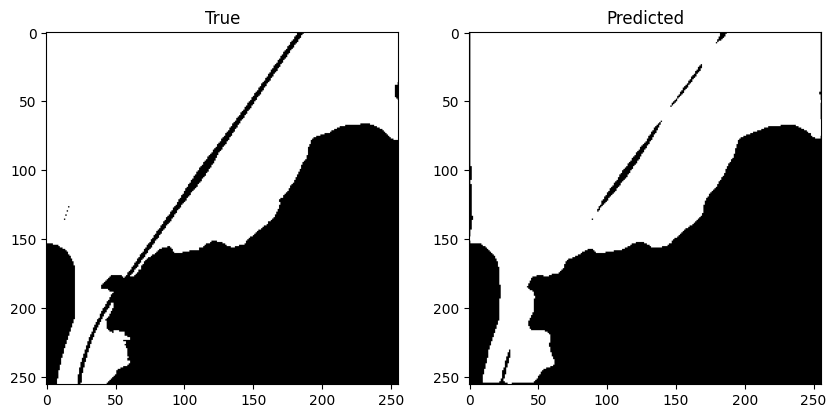

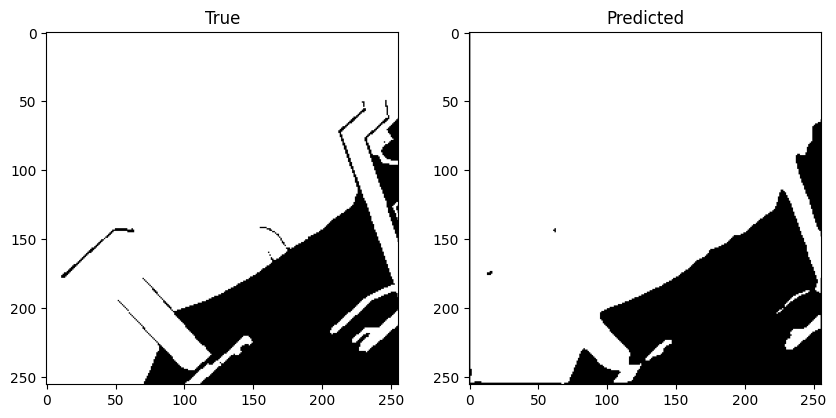

In [17]:
trainer.test_visualize(10, 0.5)

In [18]:
# !rm -r /kaggle/working/*